In [1]:
print('hi')

hi


In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
#import mpld3
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sqlalchemy_utils import database_exists, create_database
from sklearn.cluster import KMeans, MiniBatchKMeans
import psycopg2
from sqlalchemy import create_engine
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [3]:
places = ['socal', 'oc', 'newport', 'newportbeach', 'california', 'ca', 'irvine', 'tustin', 'orangecounty','missionviejo', 'costamesa', 'orange', 'huntingtonbeach']
others = ['bossbabe', 'fitfam', 'lululemon', 'bestgym', 'bestworkout', 'repost', 'photography', 'love', '2017', 'birthday', 'happybirthday', 'tbt']

In [4]:
def CollectTags(f):
    json_data = open("./SampleSet/"+f+"/"+f+".json")
    j = json.load(json_data)
    json_data.close()
    totalTags = ""
    for i in range(len(j)):
        if 'tags' in j[i].keys():
            try:
                listostring=[]
                for b in j[i]['tags']:
                    if (b.lower() in places or b.lower() in others or b == f): continue
                    else: listostring.append(b)
                string = " " + " ".join(listostring)
                #string = " " + " ".join(b for b in j[i]['tags'] if (b.lower() not in places or b.lower() not in others
                #                       or b == f))
                if ' irvine ' in string: print ("da fuck")
                totalTags += string
            except:
                pass
    return totalTags
        


In [5]:
titles = os.listdir("./SampleSet")
genres = ['HIIT circuit',"HIIT circuit", "Martial Arts", "Kickboxing", "Barre", "Yoga", "Barre", "HIIT circuit", "Yoga",
         "Cycling", "Yoga", "Yoga", "Barre", "Marital Arts", "Kickboxing", "Pilates", "Yoga", "Pilates", "Crossfit", "Crossfit",
         "Yoga", "Barre", "HIIT circuit", "Pilates", "HIIT circuit", "Cycling", "HIIT cicuit", "Kickboxing", "HIIT circuit",
         "Yoga", "Everything", "HIIT circuit", "Marital Arts", "Marital Arts", "HIIT ciruit", "Pilates", "Pilates", "Pilates", 
         "Yoga", "Yoga", "Marital Arts", "Yoga", "Yoga", "Everything", "Yoga", "Marital Arts", "Pilates", "Marital Arts",
         "Yoga", "HIIT circuit", "Cycling", "Yoga", "Yoga", "Yoga"]
studioNames = ['The 12 Life', '3D Fitness', '5 Elements', '9Round',
              'Alkalign Studio', 'Baker Ranch Yoga', 'Bar Method', 
              'Barrys Boot Camp', 'Be The Change Yoga', 'Bike 2 The Beat',
              'Bikram Yoga', 'Caffe Yoga', 'Cardio Barre', 'Carrillo Muay Thai',
              'CKO', 'Club Pilates', 'Core Power', 'Core Reform', 'Cross Fit Insanity',
              'Cross Fit Tustin', 'Ekam Yoga', 'Enerji Barre', 'Fitness On Fire',
              'Fit Pilates Studio', 'Fit Wall', 'Freedom Ride', 'HDX Fit', 'ilovekickboxing.com',
              'Kaia Fit', 'Mixx Yoga', 'Neaumix Fit', 'OC Fit', 'OCK MMA', 'One Jui Jitsu',
              'Orange Theory', 'Pilates On Purpose', 'Pilates Plus Cycle', 'Pure Barre',
              'Radiant Yoga','Ra Yoga', 'Rounder MMA', 'Spectra Yoga', 'Stella Luna Yoga',
              'Studio Fixx', 'Sun Spark Yoga', 'Team Oyama', 'The Haute Room',
              'Total MMA', 'Triad Yoga And Pilates', 'Trim Fitness Studio', 'Union Ryde',
              'Vibes Hot Yoga', 'Wild Side Yoga', 'Yoga Shakti']
hashtags = [CollectTags(f) for f in os.listdir("./SampleSet")]
ranks = [i for i in range(len(hashtags))]
print (titles)
print (len(titles), max([len(hashtag) for hashtag in hashtags]))
#print (hashtags[0])

['12life', '3dfitnessgymoc', '5elementsbruce', '9round', 'alkalignme', 'bakerranchyoga', 'barmethod', 'barrysbootcamp', 'bethechangeyoga', 'bike2thebeattustin', 'bikramyogairvine', 'caffeyoga', 'cardiobarre', 'carrillomuaythai', 'ckonorthtustin', 'clubpilates', 'corepoweryoga', 'corereform', 'crossfitinsanity', 'crossfittustin', 'ekamyoga', 'enerjibarre', 'fitnessonfire', 'fitpilatesstudio', 'fitwall', 'freedomride', 'hdxfit', 'ilovekickboxing', 'kaiafit', 'mixxyoga', 'neaumixfit', 'ocfit', 'ockmma', 'onejiujitsu', 'orangetheoryfitness', 'pilatesonpurpose', 'pilatespluscycle', 'pureempower', 'radianthotyoga', 'rayoga', 'roundersmma', 'spectrayoga', 'stellalunayoga', 'studiofixx', 'sunsparkyoga', 'teamoyama', 'thehauteroom', 'totalmmastudios', 'triadyogaandpilates', 'trimfitnessstudio', 'unionryde', 'vibeshotyoga', 'wildsideyoga', 'yogashaktistudio']
54 124855


In [6]:
savedFrame = pd.DataFrame({'name': titles, 'studioName': studioNames, 'type': genres, 'hashtags': hashtags, 'rank': ranks})

In [7]:
dbname = 'studio_db'
username = 'MeghanFrate'
pswd = 'pizza'

In [8]:
engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))

if not database_exists(engine.url):
    create_database(engine.url)

savedFrame.to_sql('studios', engine, if_exists="replace")

In [9]:
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# query:
sql_query = """
SELECT * FROM studios;
"""
data_from_sql = pd.read_sql_query(sql_query,con)

data_from_sql.head()

,index,hashtags,name,rank,studioName,type
0,0,12Nation sundaymood sundayvibes workout fitli...,12life,0,The 12 Life,HIIT circuit
1,1,dedication hardwork fitness irvinefitness ocf...,3dfitnessgymoc,1,3D Fitness,HIIT circuit
2,2,5ElementsBruce VixenShow aerialyogaisfun groi...,5elementsbruce,2,5 Elements,Martial Arts
3,3,9roundbutler workout iamstrong flex fitness f...,9round,3,9Round,Kickboxing
4,4,alkalignforlife alkaligninfinity LosAltos fit...,alkalignme,4,Alkalign Studio,Barre


In [57]:
#print(data_from_sql.loc[data_from_sql['studioName'] == "The 12 Life"]['name'].iloc[0])
print(data_from_sql.loc[data_from_sql['clusters'] == 2]['name'].values.tolist())
print(data_from_sql.loc[1]['name'])
print(frame.loc[1]['title'])

['bike2thebeattustin', 'freedomride']
3dfitnessgymoc
1                 12life
1         3dfitnessgymoc
1         barrysbootcamp
1          fitnessonfire
1                fitwall
1                 hdxfit
1                kaiafit
1                  ocfit
1                 ockmma
1            onejiujitsu
1    orangetheoryfitness
1             studiofixx
1           thehauteroom
1      trimfitnessstudio
1              unionryde
Name: title, dtype: object


In [10]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.99, max_features=200000, min_df=0.3, ngram_range=(1,1))
                                 #min_df=0.2, stop_words='english',
                                 #use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(hashtags)

print(tfidf_matrix.shape)

CPU times: user 373 ms, sys: 13.6 ms, total: 387 ms
Wall time: 391 ms
(54, 240)


In [11]:
terms = tfidf_vectorizer.get_feature_names()

In [12]:
T = (tfidf_matrix * tfidf_matrix.T).A
#print(np.unravel_index(T.argmin(), T.shape), T.min())
#print (T[2][10], T[52][2])

In [13]:
dist = 1 - cosine_similarity(tfidf_matrix)

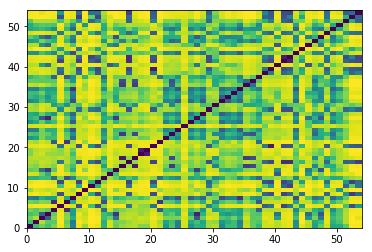

In [14]:
plt.pcolor(dist)

In [ ]:
def rankSimilarities(M):
    ordered = []
    orderedAm = []
    orderedStudios = []
    #B = np.triu(M,1)
    B=M
    iu1 = np.triu_indices(B.shape[0])
    B[iu1] = -np.inf
    np.fill_diagonal(B, -np.inf)
    for j in range(int((B.shape[0]**2-B.shape[0])/2.)):
        pair = np.unravel_index(B.argmax(), B.shape)
        ordered.append(pair)
        orderedAm.append(B.max())
        orderedStudios.append((titles[pair[0]], titles[pair[1]]))
        B[pair[0], pair[1]]=-np.inf
    #return ordered, orderedAm, orderedStudios
    return [(ordered[i], orderedAm[i], orderedStudios[i]) for i in range(len(ordered))]

In [ ]:
T = (tfidf_matrix * tfidf_matrix.T).A
rankList = rankSimilarities(T)
#rank, rankNum, rankStudios = rankSimilarities(T)
#print (rankStudios[-1])
print(rankList[2])

In [187]:
score=[]
for b in rankList:
    if titles.index('mixxyoga') in b[0]:
        if titles.index('mixxyoga') == b[0][0]:
            p = b[0][1]
        else: p = b[0][0]
        score.append((b[1], p))

In [204]:
print(score)
xs = [p[1] for p in score]
ys = [p[0] for p in score]

[(0.14021441850823255, 0), (0.14439255802331227, 1), (0.053553839153225043, 2), (0.10861395401418769, 3), (0.083669345943924361, 4), (0.53196677406698323, 5), (0.08302193180303663, 6), (0.17247709606784495, 7), (0.64309956513251132, 8), (0.17481799911006424, 9), (0.43122968857775412, 10), (0.67270523526767512, 11), (0.25088159057763665, 12), (0.028952609392201956, 13), (0.069707493118903993, 14), (0.089881899262726703, 15), (0.73962047800963504, 16), (0.11119556104598781, 17), (0.069320972807303538, 18), (0.03313046428444421, 19), (0.70945151641223392, 20), (0.15613826713540035, 21), (0.13203845111476595, 22), (0.14647745931740941, 23), (0.23320947951466764, 24), (0.027034650744930604, 25), (0.18589013664820014, 26), (0.11779926285784838, 27), (0.15112718341835071, 28), (0.24489230352014227, 30), (0.17602830144580908, 31), (0.16094321435687889, 32), (0.10085627864787693, 33), (0.22533620460014725, 34), (0.068715461632822009, 35), (0.084922520723922187, 36), (0.23134850512776317, 37), (

skip


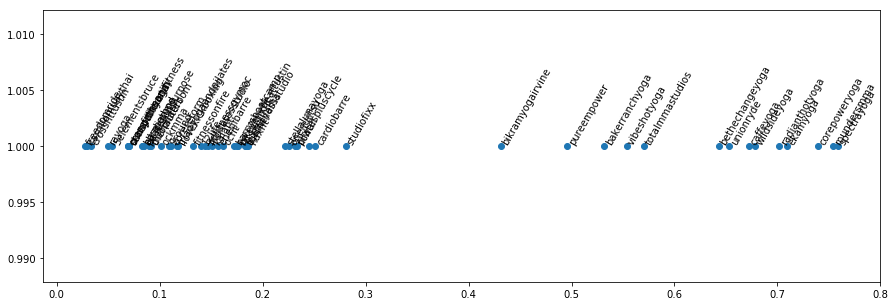

In [218]:
#score.sort(key=lambda tup: tup[1]) 


plt.figure(figsize = (15, 5))
#plt.scatter(xs, ys)
plt.scatter(ys, np.ones(len(ys)))
#plt.plot(ys)
for i, txt in enumerate(titles):
    if i == titles.index('mixxyoga'):
        print ("skip")
        continue
    if i == 53: continue
    #plt.annotate(txt, (ys[i],1), rotation=60)
    plt.text(ys[i],1, txt, {'ha': 'left', 'va': 'bottom'}, rotation=60)

In [16]:
def similarities(M, studio):
    ind = titles.index(studio)
    sims = M[ind][:]
    ordered = [(isim, sim) for isim, sim in enumerate(sims)]
    sortd = sorted(ordered, key=lambda tup: tup[1])
    return sortd

In [17]:
dense = tfidf_matrix.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=terms, index=titles)
#print(df.head(10))
s = pd.Series(df.loc['mixxyoga'])
s[s > 0].sort_values(ascending=False)[:10]

yoga                0.506407
yogaeverydamnday    0.492166
namaste             0.470987
hiit                0.246248
stretch             0.225567
cardio              0.207427
sweat               0.185167
loveyourself        0.182531
fitlife             0.155749
fitness             0.082226
Name: mixxyoga, dtype: float64

In [18]:
s = pd.Series(df.loc['corepoweryoga'])
s[s > 0].sort_values(ascending=False)[:10]

yoga                0.580930
yogaeverydamnday    0.510841
yogi                0.320658
yogalife            0.303645
namaste             0.279347
fitness             0.155397
core                0.133679
practice            0.101494
instagood           0.089591
meditation          0.076905
Name: corepoweryoga, dtype: float64

In [19]:
num_clusters = 7

km = KMeans(n_clusters=num_clusters, n_init=100)
#mbkm = MiniBatchKMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)
#%time mbkm = mbkm.fit(tfidf_matrix)

clusters = km.labels_.tolist()
#c = mbkm.labels_.tolist()
#print(km.cluster_centers_.shape)
#print(mbkm.cluster_centers_.shape)

CPU times: user 1.98 s, sys: 4.68 ms, total: 1.98 s
Wall time: 1.99 s


In [20]:
studios = { 'title': titles, 'rank': ranks, 'hashtags': hashtags, 'cluster': clusters, 'genre': genres }

frame = pd.DataFrame(studios, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])
print(frame.head(10))
#frame2 = pd.DataFrame(studios, index = [c] , columns = ['rank', 'title', 'cluster', 'genre'])

   rank               title  cluster         genre
1     0              12life        1  HIIT circuit
1     1      3dfitnessgymoc        1  HIIT circuit
3     2      5elementsbruce        3  Martial Arts
3     3              9round        3    Kickboxing
6     4          alkalignme        6         Barre
0     5      bakerranchyoga        0          Yoga
6     6           barmethod        6         Barre
1     7      barrysbootcamp        1  HIIT circuit
0     8     bethechangeyoga        0          Yoga
2     9  bike2thebeattustin        2       Cycling


In [21]:
data_from_sql['clusters'] = clusters
clusternum = (data_from_sql.loc[data_from_sql['name'] == 'mixxyoga'])['clusters'].iloc[0]
print((data_from_sql.loc[29])['clusters'])
print(data_from_sql.head(10))

0
   index                                           hashtags  \
0      0   12Nation sundaymood sundayvibes workout fitli...   
1      1   dedication hardwork fitness irvinefitness ocf...   
2      2   5ElementsBruce VixenShow aerialyogaisfun groi...   
3      3   9roundbutler workout iamstrong flex fitness f...   
4      4   alkalignforlife alkaligninfinity LosAltos fit...   
5      5    yoga yogalove hathayoga  yoga sunsalutation ...   
6      6   dontbefooledbythesmile wearesoproud strong mo...   
7      7   turnUP likeagirl runhappy wilhelminafitness p...   
8      8   bayareayoga conscioussanjose yogaisnotahobbyi...   
9      9   sunsethike trail spin dogontheloose itslikeXm...   

                 name  rank          studioName          type  clusters  
0              12life     0         The 12 Life  HIIT circuit         1  
1      3dfitnessgymoc     1          3D Fitness  HIIT circuit         1  
2      5elementsbruce     2          5 Elements  Martial Arts         3  
3       

In [40]:
aa = similarities(dist, "mixxyoga")
print(titles[aa[1][0]])
for bi, b in enumerate(aa):
    if data_from_sql.loc[b[0]]['clusters'] == clusternum:
        continue
    secondsimilar = b[0]
    break
print (secondsimilar)
    
print(titles.index('mixxyoga'))
print(titles[42])

stellalunayoga
30
29
stellalunayoga


In [23]:
frame['cluster'].value_counts()

0    16
1    15
3     8
4     6
6     5
5     2
2     2
Name: cluster, dtype: int64

In [24]:
(frame.loc[frame['title'] == '12life'])['cluster'].iloc[0]
#frame.loc[[frame['cluster'] == 2]]
frame[frame['cluster'] == 2]['title'].tolist()

['bike2thebeattustin', 'freedomride']

grouped = frame['rank'].groupby(frame['cluster']) #groupby cluster for aggregation purposes

grouped.mean() #average rank (1 to 100) per cluster

In [25]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

cluster_names = {}
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    cluster_names[i]=""
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        cluster_names[i] += terms[ind].split(' ')[0] + " "
        print(' %s' % terms[ind].split(' ')[0], end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d group:" % i, end='')
    for g in frame.loc[i]['genre'].values.tolist():
        print(' %s,' % g, end='')
    print() #add whitespace
    print() #add whitespace
    
print()

Top terms per cluster:

Cluster 0 words: yoga, yogaeverydamnday, namaste, yogi, meditation, community,

Cluster 0 titles: bakerranchyoga, bethechangeyoga, bikramyogairvine, caffeyoga, corepoweryoga, ekamyoga, mixxyoga, radianthotyoga, rayoga, spectrayoga, stellalunayoga, sunsparkyoga, triadyogaandpilates, vibeshotyoga, wildsideyoga, yogashaktistudio,

Cluster 0 group: Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga,

Cluster 1 words: fitness, workout, fitnessmotivation, fit, bootcamp, fitlife,

Cluster 1 titles: 12life, 3dfitnessgymoc, barrysbootcamp, fitnessonfire, fitwall, hdxfit, kaiafit, ocfit, ockmma, onejiujitsu, orangetheoryfitness, studiofixx, thehauteroom, trimfitnessstudio, unionryde,

Cluster 1 group: HIIT circuit, HIIT circuit, HIIT circuit, HIIT circuit, HIIT circuit, HIIT cicuit, HIIT circuit, HIIT circuit, Marital Arts, Marital Arts, HIIT ciruit, Everything, Pilates, HIIT circuit, Cycling,

Cluster 2 words: cardio, getfit, p

In [26]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5:'blue', 6:'cyan'}

In [27]:
from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

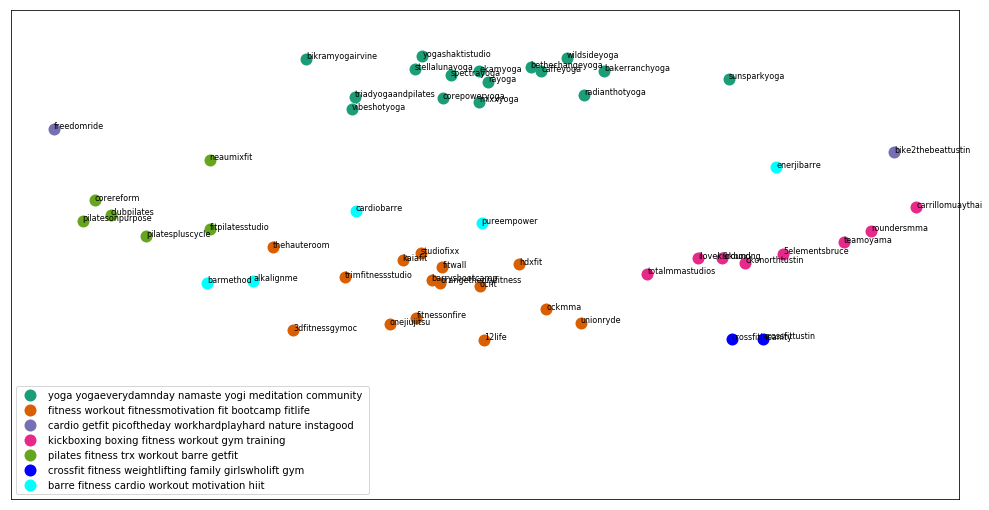

In [28]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#ax.set_xlim([-1,1] )
ax.set_ylim([-1.3,.85])
#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  

    
    
#plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

<class 'dict'>


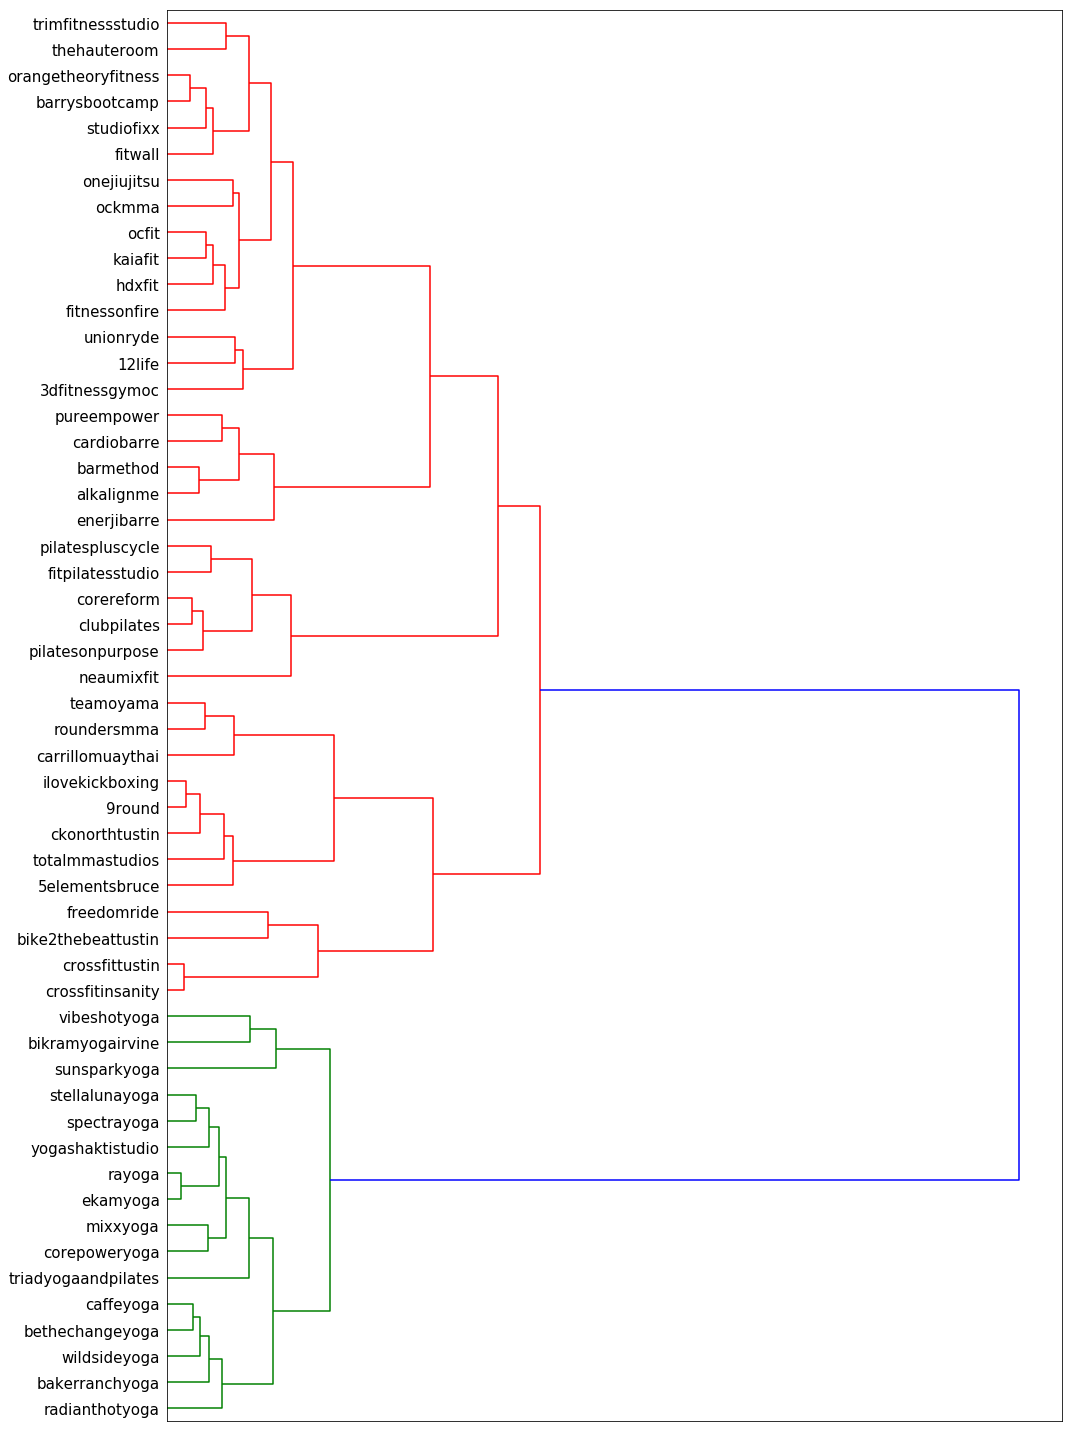

In [84]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles, leaf_font_size=15);

#plt.ylabel("classes",fontsize=20)


plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

In [42]:
import difflib

In [50]:
print (difflib.get_close_matches('Mixx', studioNames, cutoff=0.5))


['Mixx Yoga']
